In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import torch 
import os
from io import StringIO

ROOT_DIR = "/home/jovyan/Quan/Data-Competition"

In [729]:
true_train_path = os.path.join(ROOT_DIR, "dataset82/labels/train")
true_val_path = os.path.join(ROOT_DIR, "dataset82/labels/val")

model_train_path = os.path.join(ROOT_DIR, "prediction/crop_train")
model_val_path = os.path.join(ROOT_DIR, "prediction/crop_val")


In [1]:
# x_center_norm, y_center_norm, width_norm, height_norm đây ạ 
def box_iou(box1, box2):
    # https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py
    """
    Return intersection-over-union (Jaccard index) of boxes.
    Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
    Arguments:
        box1 (Tensor[N, 4])
        box2 (Tensor[M, 4])
    Returns:
        iou (Tensor[N, M]): the NxM matrix containing the pairwise
            IoU values for every element in boxes1 and boxes2
    """

    def box_area(box):
        # box = 4xn
        return (box[2] - box[0]) * (box[3] - box[1])

    area1 = box_area(box1.T)
    area2 = box_area(box2.T)
    
    # inter(N,M) = (rb(N,M,2) - lt(N,M,2)).clamp(0).prod(2)
    inter = (torch.min(box1[:, None, 2:], box2[:, 2:]) - torch.max(box1[:, None, :2], box2[:, :2])).clamp(0).prod(2)
    return inter / (area1[:, None] + area2 - inter)  # iou = inter / (area1 + area2 - inter)

def xywhn2xyxy(x, w=640, h=640, padw=0, padh=0):
    # Convert nx4 boxes from [x, y, w, h] normalized to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = w * (x[:, 0] - x[:, 2] / 2) + padw  # top left x
    y[:, 1] = h * (x[:, 1] - x[:, 3] / 2) + padh  # top left y
    y[:, 2] = w * (x[:, 0] + x[:, 2] / 2) + padw  # bottom right x
    y[:, 3] = h * (x[:, 1] + x[:, 3] / 2) + padh  # bottom right y
    return y


In [580]:
def show_sample (data, title=None, ncol=10):
    
    nrow =  len(data) // ncol + min ( len(data) % ncol, 1 )
    nrow = max ( nrow, 1)
    files = [ name for name in  data["name"].values ]
    labels = data["label"].values

    fig, axes = plt.subplots(nrow, ncol, figsize=(10,  nrow), squeeze=False)
    axes = axes.flatten()
    
    for i,ax in enumerate(axes):
        
        if i < len(files):
            file = files[i]
            label = labels[i]
            image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
            ax.imshow(image, cmap='Greys')
            ax.set_title(f"{label}")
        ax.axis("off")
    if title:
        plt.suptitle(title)
    plt.tight_layout()    
    plt.savefig('diagram.png')

labels = [0, 1, 2]
    
def show_label_disributions (data):
    def absolute_value(val):
        a = np.round(val/100.*y.sum(), 0)
        return int(a)

    d = data.groupby(["label"]).agg({"name":"count"})["name"].to_dict()
    y = np.array([d[label] for label in labels[::-1]])
    
    plt.figure(figsize=(6,6))
    plt.pie(y, labels=labels[::-1], autopct=absolute_value)
    plt.title("class distributions")
    
    plt.show() 
    
def show_mapping (data):
    plt.figure(figsize=(10,10))
    sns.scatterplot(x="iou", y="confidence", hue="correctness", data = data)
    plt.text(0.01, 0.1, "hard-to-learn", horizontalalignment='left', size='medium', color='red', weight='semibold')
    plt.text(0.1, 0.95, "easy-to-learn", horizontalalignment='left', size='medium', color='green', weight='semibold')
    plt.text(0.35, 0.5, "ambiguous", horizontalalignment='left', size='medium', color='blue', weight='semibold')

    plt.plot()
    
def xywhn2xyxy(x, w=640, h=640, padw=0, padh=0):
    # Convert nx4 boxes from [x, y, w, h] normalized to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = w * (x[:, 0] - x[:, 2] / 2) + padw  # top left x
    y[:, 1] = h * (x[:, 1] - x[:, 3] / 2) + padh  # top left y
    y[:, 2] = w * (x[:, 0] + x[:, 2] / 2) + padw  # bottom right x
    y[:, 3] = h * (x[:, 1] + x[:, 3] / 2) + padh  # bottom right y
    return y
    

In [747]:
i = [1,3,4]
for ij in j : 
    if not ij in [1]:
        print(ij)

2
3


In [524]:
def cal_epoch_metrics_non_normal(true_prediction, epoch_prediction):
    iou = []
    conf = []
    correct = []
    
    for key, values in true_prediction.items():
        img_cor, img_conf ,img_iou = cal_img_metrics(values, epoch_prediction[key])
        
        iou.append(np.sum(img_iou) / len(values))
        conf.append(np.sum(img_conf) / len(values))
        correct.append(np.sum(img_cor) / len(values))
    
    return correct, conf, iou

In [525]:
correct, conf, iou = cal_epoch_metrics_non_normal(true_prediction, model_prediction[0])

tensor([[316.6851, 102.1684, 347.3155, 153.8310]])
tensor([[317.4997,  91.5553, 344.4997, 141.3331],
        [329.9997, 125.3335, 359.9997, 176.0002]])
tensor([[174.5106, 355.4894, 217.8368, 390.2310],
        [  8.5664, 309.6183,  29.5335, 393.2765]])
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.]])
tensor([[556.1925, 167.1110, 572.7932, 225.7779],
        [358.2496, 354.2221, 397.7498, 426.2221]])
tensor([[369.5001, 375.1111, 412.0001, 453.3331],
        [361.0002, 352.0000, 402.0002, 428.4442],
        [559.9997, 186.6668, 585.9997, 248.8890]])
tensor([[463.8477, 291.6041, 487.1404, 335.3963]])
tensor([[427.0000, 278.2221, 449.0000, 342.2220]])
tensor([[391.0648, 296.4479, 417.3550, 356.7190]])
tensor([[391.0001, 288.0000, 420.0002, 364.4442],
        [398.5001, 300.4442, 427.0001, 380.4442]])
tensor([[-46.2502, 127.5552,  57.2499, 363.1110]])
tensor([[0., 0., 0., 0.]])
tensor([[326.4998, 166.2220, 356.4998, 212.4442]])
tensor([[319.0001, 155.5553, 346.5001, 213.3331],
        [

In [528]:
def cal_metrics_non_normal(true_prediction, model_prediction):
    print("cal not normal metrics")
    
    img_name = []
     
  
    for key, values in true_prediction.items():
        img_name.append(key)
        
    total_conf = np.zeros(len(img_name))
    total_cor = np.zeros(len(img_name))
    total_iou = np.zeros(len(img_name))
    
        
        
    for idx, epoch_prediction in enumerate(model_prediction):
    # return a dict of results for each epoch
        epoch_correctness, epoch_conf, epoch_iou = cal_epoch_metrics_non_normal(true_prediction, epoch_prediction)
        
        total_conf = np.add(total_conf, np.array(epoch_conf))
        total_cor = np.add(total_cor, np.array(epoch_correctness))
        total_iou = np.add(total_iou, np.array(epoch_iou))
                
    
    return img_name, total_conf / 100, total_cor / 100, total_iou / 100 


In [496]:
def load_true_prediction(path):
    true_prediction = {}

    for filename in os.listdir(path):
        if not filename in [".ipynb_checkpoints", '891.txt', '853.txt']:
            img_path = os.path.join(path, filename)
            temp = []
            with open(img_path) as f : 
                lines = f.readlines()
                for line in lines : 
                    c = StringIO(line)
                    num_line = np.loadtxt(c)
                    temp.append(num_line)

            true_prediction[f"{filename}"] = temp

    true_prediction = {key : value for key, value in true_prediction.items() if value}
    
    return true_prediction
    

In [732]:
def load_model_prediction(path):
    model_prediction = []

    for i in range(0, 100, 5):
        epoch_prediction = {}
        
        epoch_path = os.path.join(path, f"epoch_{i}/labels")
        
        for filename in os.listdir(epoch_path):
            if not filename in [".ipynb_checkpoints"]:
                img_path = os.path.join(epoch_path, filename)
                temp = []
                with open(img_path) as f : 
                    lines = f.readlines()
                    for line in lines : 
                        c = StringIO(line)
                        num_line = np.loadtxt(c)
                        temp.append(num_line)
                epoch_prediction[filename] = temp
        model_prediction.append(epoch_prediction)
    
    return model_prediction



In [208]:
import copy

def fillna(true_prediction, model_prediction):
    non_null_model_prediction = copy.deepcopy(model_prediction)
    
    for epoch_prediction in non_null_model_prediction:
        for key, value in epoch_prediction.items():
            if len(epoch_prediction[key]) < len(true_prediction[key]):
                for _ in range(len(true_prediction[key]) - len(epoch_prediction[key])):
                    epoch_prediction[key].append([5, 0, 0, 0, 0, 1])
    
    return non_null_model_prediction

In [209]:
def true_pred_bboxes(true_prediction):

    pred_tensor = torch.Tensor(true_prediction)
    bboxes = pred_tensor[:, 1:]
    bboxes = xywhn2xyxy(bboxes)
    
    return bboxes

def model_pred_bboxes(model_prediction):
 
    pred_tensor = torch.Tensor(model_prediction)
    bboxes = xywhn2xyxy(pred_tensor[:, 1:-1])

    return bboxes

In [511]:
model_prediction[1]['655.txt']

[array([1.       , 0.0222656, 0.595833 , 0.0445312, 0.122222 , 0.389648 ]),
 array([0.       , 0.0214844, 0.583333 , 0.0429688, 0.116667 , 0.486816 ])]

In [509]:
true_prediction['655.txt']

[array([1.        , 0.30652142, 0.58259408, 0.06769708, 0.05428374]),
 array([1.        , 0.02976556, 0.54913658, 0.03276112, 0.13071583])]

In [507]:
cor, conf, iou = cal_img_metrics(true_prediction['655.txt'], model_prediction[0]['655.txt'])

KeyError: '655.txt'

In [526]:
def cal_img_metrics(true_pred, epoch_pred):
    
    true_bboxes = true_pred_bboxes(true_pred)
    pred_bboxes = model_pred_bboxes(epoch_pred)
    
#     print(true_bboxes)
#     print(pred_bboxes)

    iou_mat = box_iou(true_bboxes, pred_bboxes)

    def optimal_order(mat):
        
        current_iou = np.zeros((len(mat), len(mat[0])))
        table= []
            
        for i in range(len(mat)):
            table.append([])
            for _ in range(len(mat[0])):
                table[i].append([])
        
        for i in range(len(mat[0])):
            current_iou[-1][i] = mat[-1][i]
            table[-1][i].append([i])
            
        for i in range(len(mat) - 2, -1, -1):
            for j in range(len(mat[0])):
                for idx, paths in enumerate(table[i+1]):            
                    for path in paths:
                        if j not in path:
                        
                            if mat[i][j] + current_iou[i+1][idx] > current_iou[i][j]:
                                current_iou[i][j] = mat[i][j] + current_iou[i+1][idx]
                                table[i][j] = [[j]+path]
                            elif mat[i][j] + current_iou[i+1][idx] == current_iou[i][j]:
                                table[i][j].append([j]+path)
                                
        pos_max = np.argmax(np.array(current_iou[0]))

        return table[0][pos_max]
    
    
    orders = optimal_order(iou_mat)
    
    correctness_map = np.zeros((len(true_bboxes),len(pred_bboxes)))
    for true_pos in range(len(true_bboxes)):
        for pred_pos in range(len(pred_bboxes)):
            if true_pred[true_pos][0] == epoch_pred[pred_pos][0]:
                correctness_map[true_pos][pred_pos] = 1
                
    if len(orders) > 1:
        max_correctness = 0
        best_order = []
        for order in orders : 
            order_correctness = 0
            for true_pos, pred_pos in enumerate(order):
                order_correctness += correctness_map[true_pos][pred_pos]
            if order_correctness >= max_correctness:
                best_order = order
    else: 
        best_order = orders[0]

    iou = [iou_mat[i][value] for i, value in enumerate(best_order)]
    correctness_map = correctness_map.tolist()
    cor = [correctness_map[i][value] for i, value in enumerate(best_order)]
    conf = [epoch_pred[value][-1] if cor[i] == 1 else (1-epoch_pred[value][-1]) / 4 for i, value in enumerate(best_order)]

    return cor, conf, iou

In [744]:
def cal_epoch_metrics(true_prediction, epoch_prediction):
    iou = []
    conf = []
    correct = []
    
    for key, values in true_prediction.items():
        print(key)
        img_cor, img_conf ,img_iou = cal_img_metrics(values, epoch_prediction[key])
        
        iou += img_iou
        conf += img_conf
        correct += img_cor

    return correct, conf, iou
    

In [335]:
for key, value in val_true_prediction.items():
    for i in range(100):
        
        if len(value) > len(val_model_prediction[i][key]):
            print(key)
            print(i)

KeyError: '882.txt'

In [502]:
def cal_metrics(true_prediction, model_prediction):            
    pred_pos = []
    img_name = []

    for key, values in true_prediction.items():
        for i in range(len(values)):
            pred_pos.append(i)
            img_name.append(key)
    
    total_conf = np.zeros(len(img_name))
    total_cor = np.zeros(len(img_name))
    total_iou = np.zeros(len(img_name))
            
    
    for idx, epoch_prediction in enumerate(model_prediction):
        print(idx)
        # return a dict of results for each epoch
        epoch_correctness, epoch_conf, epoch_iou = cal_epoch_metrics(true_prediction, epoch_prediction)
        cal_metrics
        total_conf = np.add(total_conf, np.array(epoch_conf))
        total_cor = np.add(total_cor, np.array(epoch_correctness))
        total_iou = np.add(total_iou, np.array(epoch_iou))
            
    return pred_pos, img_name, total_conf / 20, total_cor / 20, total_iou / 20 
    

In [733]:
val_true_prediction = load_true_prediction(true_val_path)
val_model_prediction = load_model_prediction(model_val_path)

rest = []

for epoch_pred in val_model_prediction:
    temp_rest = [txt for txt in val_true_prediction if txt not in epoch_pred]
    rest.append(temp_rest)
    
for i in range(20):
    for missing_img in rest[i]:
        temp = []
        for _ in range(len(val_true_prediction.get(missing_img))):
            temp.append([5, 0, 0, 0, 0, 1])
        val_model_prediction[i][missing_img] = temp

val_model_prediction = fillna(val_true_prediction, val_model_prediction)
            


In [737]:
len(val_true_prediction)

418

In [518]:
rest = []

for epoch_pred in model_prediction:
    temp_rest = [txt for txt in true_prediction if txt not in epoch_pred]
    rest.append(temp_rest)

rest

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

In [739]:
true_prediction = load_true_prediction(true_train_path)
model_prediction = load_model_prediction(model_train_path)

rest = []

for epoch_pred in model_prediction:
    temp_rest = [txt for txt in true_prediction if txt not in epoch_pred]
    rest.append(temp_rest)

for i in range(20):
    for missing_img in rest[i]:
        temp = []
        for _ in range(len(true_prediction.get(missing_img))):
            temp.append([5, 0, 0, 0, 0, 1])
        model_prediction[i][missing_img] = temp

model_prediction = fillna(true_prediction, model_prediction)
            

In [740]:
len(true_prediction)

1788

In [529]:
img_name, final_conf, final_cor, final_iou = cal_metrics_non_normal(true_prediction, model_prediction)

cal not normal metrics


In [530]:
len(img_name)

771

In [745]:
pred_pos, img_name, final_conf, final_cor, final_iou = cal_metrics(true_prediction, model_prediction)

0
638_1.txt
794_16.txt
938_14.txt
313_8.txt
313_18.txt
628_36_4.txt


KeyboardInterrupt: 

In [727]:
val_pred_pos, val_img_name, val_final_conf, val_final_cor, val_final_iou = cal_metrics(val_true_prediction, val_model_prediction)

0


KeyError: '609.txt'

In [354]:
both_pred_pos = pred_pos + val_pred_pos
both_img_name = img_name + val_img_name
both_final_conf = list(final_conf) + list(val_final_conf)
both_final_cor = list(final_cor) + list(val_final_cor)
both_final_iou = list(final_iou) + list(val_final_iou)

In [358]:
import csv

path = os.path.join(ROOT_DIR, "csv_file_val")

# open the file in the write mode
f = open(path, 'w')

# create the csv writer
writer = csv.writer(f)

writer.writerow(['name', 'pos'])

for x in range(len(val_img_name)):
    writer.writerow([val_img_name[x], val_pred_pos[x]])
# write a row to the csv file

# close the file
f.close()

import pandas as pd

table_v = pd.read_csv(path)
table_v['confidence'] = val_final_conf
table_v['variability'] = val_final_iou 
table_v['correctness'] = val_final_cor


In [423]:
import csv

path = os.path.join(ROOT_DIR, "csv_file_both")

# open the file in the write mode
f = open(path, 'w')

# create the csv writer
writer = csv.writer(f)

writer.writerow(['name', 'pos', 'confidence', 'correctness', 'iou'])

for x in range(len(both_img_name)):
    writer.writerow([both_img_name[x], both_pred_pos[x], both_final_conf[x], both_final_cor[x], both_final_iou[x]])
# write a row to the csv file

# close the file
f.close()


In [424]:
import pandas as pd

table = pd.read_csv(path)


In [425]:
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         1520 non-null   object 
 1   pos          1520 non-null   int64  
 2   confidence   1520 non-null   float64
 3   correctness  1520 non-null   float64
 4   iou          1520 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 59.5+ KB


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='confidence', ylabel='Density'>

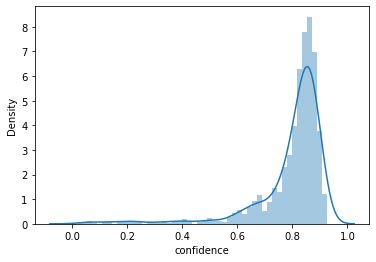

In [304]:
sns.distplot(table_t.confidence)

In [300]:
high_conf.describe()

,pos,confidence,variability,correctness
count,1156.000000,1156.000000,1156.000000,1156.000000
mean,0.519896,0.824007,0.827440,0.975208
std,0.861159,0.067017,0.048226,0.034335
min,0.000000,0.603840,0.640415,0.770000
25%,0.000000,0.798740,0.800083,0.970000
50%,0.000000,0.843114,0.836198,0.990000
75%,1.000000,0.869874,0.862755,0.990000
max,6.000000,0.926445,0.914587,1.000000


In [489]:
import random

he = [9,7, 8, 3, 5, 5, 2, 12,56, 87]
ho = [1 , 2, 3]

# randomly pick images to exchange 
rd_pos = random.sample(range(len(he)), len(ho))
train2val = [img for idx, img in enumerate(he) if idx in rd_pos]

train2val



[9, 5, 87]

In [478]:
train2val


[5, 2, 12]

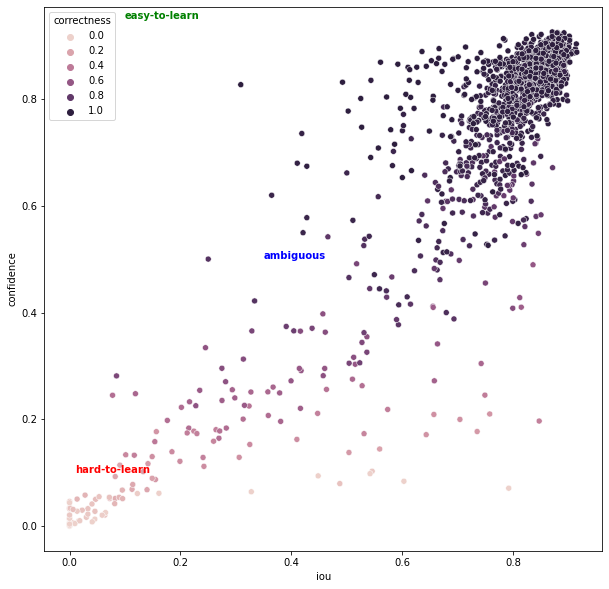

In [438]:
show_mapping(table)

In [364]:
low_conf

,name,pos,confidence,variability,correctness
40,639.txt,0,0.249632,0.378741,0.55
42,639.txt,2,0.429144,0.571692,0.77
48,627.txt,2,0.428327,0.811676,0.61
50,627.txt,4,0.377463,0.592924,0.82
51,627.txt,5,0.232993,0.216310,0.52
...,...,...,...,...,...
1505,846.txt,0,0.305349,0.504022,0.70
1507,839.txt,0,0.295548,0.460046,0.60
1508,936.txt,0,0.365837,0.328676,0.70
1510,796.txt,0,0.139377,0.184603,0.32


In [378]:
low_conf = table[table.confidence < 0.5]
low_conf_v = table_v[table_v.confidence < 0.5]

In [379]:
low_conf_name = low_conf[["name", "pos"]]
low_conf_name_v = low_conf_v[["name", "pos"]]

In [380]:
name_list = low_conf_name.values.tolist() 
name_list_v = low_conf_name_v.values.tolist() 

In [397]:
true_prediction['639.txt']

[array([0.      , 0.687891, 0.020139, 0.027344, 0.0375  ]),
 array([0.      , 0.788672, 0.577083, 0.064844, 0.098611]),
 array([1.      , 0.844531, 0.015278, 0.028125, 0.027778])]

In [419]:
str = []
for key, pos in name_list : 
    label = true_prediction[key][pos][0]
    x_center = true_prediction[key][pos][1]
    y_center = true_prediction[key][pos][2]
    w_norm = true_prediction[key][pos][3]
    h_norm = true_prediction[key][pos][4]
    
    str.append(f"{key} {label} {x_center} {y_center} {w_norm} {h_norm}\n") 


In [418]:
str_v = []
for key, pos in name_list_v : 
    label = val_true_prediction[key][pos][0]
    x_center = val_true_prediction[key][pos][1]
    y_center = val_true_prediction[key][pos][2]
    w_norm = val_true_prediction[key][pos][3]
    h_norm = val_true_prediction[key][pos][4]
    
    str_v.append(f"{key} {label} {x_center} {y_center} {w_norm} {h_norm}\n") 


In [572]:
h = [1,2,3,4,5,6,7,8,9,10]
j = [1,2,3]

import random

rd_pos = random.sample(range(len(h)), len(j))
train2val = [img for idx, img in enumerate(h) if idx in rd_pos]
    
train2val

[2, 6, 7]

In [453]:
t = [1, 3, 4]
l = []
for i in range(4):
    l.append(np.sum(t) /2)

h = np.zeros(4)
n = h + l

k = [c for c in n if c > 5]
k


[]

In [422]:
low_conf_path = os.path.join(ROOT_DIR, "low_conf_info")

low_conf_file = open(low_conf_path, "w")
low_conf_file.writelines(final_str)




In [455]:
t = ['451.txt']
h = [f.rstrip('.txt') for f in t]
h

['451']

In [457]:
os.remove(fname) for fname in os.listdir(ROOT_DIR + "/test") if fname.rstrip('.txt') == 't'

SyntaxError: invalid syntax (<ipython-input-457-ce7f0006108f>, line 1)

In [469]:
path = ROOT_DIR + "/test"

for fname in os.listdir(path):
    if fname.rstrip('.txt') == '543':
        print(fname)
        os.remove(os.path.join(path, fname))

543.txt


In [ ]:
img_name, final_conf, final_cor, final_iou = cal_metrics_non_normal(true_prediction, model_prediction)

In [543]:
def iou_conf_constraint(file_list, 
                        avg_conf, 
                        avg_iou, 
                        conf_thresh, 
                        iou_thresh,
                       higher=True):
    
    if higher : 
        qualified_conf_pos = [idx for idx, conf in enumerate(avg_conf) if conf > conf_thresh]
        qualified_iou_pos = [idx for idx, iou in enumerate(avg_iou) if iou > iou_thresh]
       
    else: 
        qualified_conf_pos = [idx for idx, conf in enumerate(avg_conf) if conf < conf_thresh]
        qualified_iou_pos = [idx for idx, iou in enumerate(avg_iou) if iou < iou_thresh]
        
    satis_both = [pos for pos in qualified_conf_pos if pos in qualified_iou_pos]
    
    satis_img = [img for idx, img in enumerate(file_list) if idx in satis_both]
    
    return satis_img

In [542]:
len(train_high_iou_conf)

447

In [540]:
 train_high_iou_conf = iou_conf_constraint(img_name, 
                                              final_conf, 
                                              final_cor, 
                                              0.8, 
                                              0.8)
    
# val_low_iou_conf = iou_conf_constraint(val_file_list, 
#                                        val_avg_conf, 
#                                        val_avg_iou, 
#                                        0.4, 
#                                        0.4, 
#                                         higher=False)

[0, 2, 4, 6, 8, 11, 13, 15, 16, 17, 18, 19, 20, 23, 25, 26, 28, 30, 32, 33, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 51, 52, 54, 56, 57, 58, 61, 62, 63, 64, 65, 66, 68, 69, 70, 74, 77, 80, 81, 84, 85, 88, 90, 91, 92, 94, 96, 98, 103, 106, 110, 112, 115, 118, 121, 122, 123, 124, 126, 128, 129, 130, 131, 132, 133, 135, 136, 140, 141, 143, 144, 146, 147, 148, 149, 150, 151, 152, 154, 155, 157, 158, 159, 160, 162, 163, 166, 167, 168, 169, 172, 173, 177, 180, 181, 182, 185, 186, 187, 191, 193, 199, 200, 201, 202, 204, 205, 206, 208, 209, 211, 212, 213, 214, 215, 216, 217, 218, 221, 222, 223, 224, 225, 226, 227, 230, 231, 232, 234, 235, 236, 238, 239, 240, 241, 242, 244, 246, 249, 250, 252, 253, 254, 255, 259, 262, 265, 266, 267, 268, 269, 270, 274, 275, 277, 279, 280, 281, 282, 285, 286, 287, 288, 290, 293, 294, 295, 296, 297, 300, 301, 303, 304, 306, 309, 311, 313, 314, 315, 318, 322, 323, 325, 327, 329, 330, 331, 332, 333, 334, 336, 337, 338, 339, 342, 343, 344, 346, 347, 351, 352, 353, 35

In [546]:
def save_mapping (data, folder, filename):
    plt.figure(figsize=(11,11))
    sns.scatterplot(x="iou", y="confidence", hue="correctness", data = data)
    plt.text(0.01, 0.1, "hard-to-learn", horizontalalignment='left', size='medium', color='red', weight='semibold')
    plt.text(0.1, 0.95, "easy-to-learn", horizontalalignment='left', size='medium', color='green', weight='semibold')
    plt.text(0.35, 0.5, "ambiguous", horizontalalignment='left', size='medium', color='blue', weight='semibold')

    plt.savefig(os.path.join(folder, filename))  
    

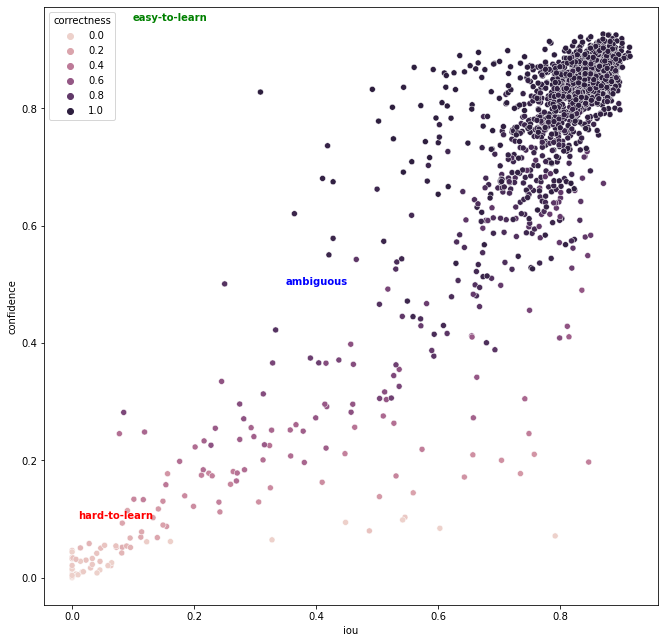

In [548]:
save_mapping(table,  os.path.join(ROOT_DIR, "transfer_results/iter_1"), "heelo.png")

In [592]:
path = ROOT_DIR + "/transfer_results/iter_1/save_results_val"

table = pd.read_csv(path)

low = table[table.confidence < 0.4]
low = low[low.iou < 0.4]


In [610]:
def rotate_box(corners,angle,  cx, cy, h, w):
    
    """Rotate the bounding box.
    
    
    Parameters
    ----------
    
    corners : numpy.ndarray
        Numpy array of shape `N x 8` containing N bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`
    
    angle : float
        angle by which the image is to be rotated
        
    cx : int
        x coordinate of the center of image (about which the box will be rotated)
        
    cy : int
        y coordinate of the center of image (about which the box will be rotated)
        
    h : int 
        height of the image
        
    w : int 
        width of the image
    
    Returns
    -------
    
    numpy.ndarray
        Numpy array of shape `N x 8` containing N rotated bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`
    """

    corners = corners.reshape(-1,2)
    corners = np.hstack((corners, np.ones((corners.shape[0],1), dtype = type(corners[0][0]))))
    
    M = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
    
    
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cx
    M[1, 2] += (nH / 2) - cy
    # Prepare the vector to be transformed
    calculated = np.dot(M,corners.T).T
    
    calculated = calculated.reshape(-1,8)
    
    return calculated

In [631]:
def get_corners(bboxes):
    
    """Get corners of bounding boxes
    
    Parameters
    ----------
    
    bboxes: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
    
    returns
    -------
    
    numpy.ndarray
        Numpy array of shape `N x 8` containing N bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`      
        
    """
    print(bboxes)
    
    width = (bboxes[:,2] - bboxes[:,0]).reshape(-1,1)
    height = (bboxes[:,3] - bboxes[:,1]).reshape(-1,1)
    
    x1 = bboxes[:,0].reshape(-1,1)
    y1 = bboxes[:,1].reshape(-1,1)
    
    x2 = x1 + width
    y2 = y1 
    
    x3 = x1
    y3 = y1 + height
    
    x4 = bboxes[:,2].reshape(-1,1)
    y4 = bboxes[:,3].reshape(-1,1)
    
    corners = np.hstack((x1,y1,x2,y2,x3,y3,x4,y4))
    
    return corners

In [629]:
class RandomRotate(object):
    """Randomly rotates an image    
    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    angle: float or tuple(float)
        if **float**, the image is rotated by a factor drawn 
        randomly from a range (-`angle`, `angle`). If **tuple**,
        the `angle` is drawn randomly from values specified by the 
        tuple
        
    Returns
    -------
    
    numpy.ndaaray
        Rotated image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, angle = 10):
        self.angle = angle
        
        if type(self.angle) == tuple:
            assert len(self.angle) == 2, "Invalid range"  
            
        else:
            self.angle = (-self.angle, self.angle)
            
    def __call__(self, img, bboxes):
    
        angle = random.uniform(*self.angle)
    
        w,h = img.shape[1], img.shape[0]
        cx, cy = w//2, h//2
    
        img = rotate_im(img, angle)
    
        corners = get_corners(bboxes)
    
        corners = np.hstack((corners, bboxes[:,4:]))
    
    
        corners[:,:8] = rotate_box(corners[:,:8], angle, cx, cy, h, w)
    
        new_bbox = get_enclosing_box(corners)
    
    
        scale_factor_x = img.shape[1] / w
    
        scale_factor_y = img.shape[0] / h
    
        img = cv2.resize(img, (w,h))
    
        new_bbox[:,:4] /= [scale_factor_x, scale_factor_y, scale_factor_x, scale_factor_y] 
    
        bboxes  = new_bbox
    
        bboxes = clip_box(bboxes, [0,0,w, h], 0.25)
    
        return img, bboxes


In [677]:
import cv2 
import numpy as np


def draw_rect(im, cords, color = None):
    """Draw the rectangle on the image
    
    Parameters
    ----------
    
    im : numpy.ndarray
        numpy image 
    
    cords: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
        
    Returns
    -------
    
    numpy.ndarray
        numpy image with bounding boxes drawn on it
        
    """
    
    im = im.copy()
    
    print(cords)
    cords = cords[:,:4]
    cords = cords.reshape(-1,4)
    print(cords)
    if not color:
        color = [255,0,0]
    for cord in cords:
        
        pt1, pt2 = (cord[0], cord[1]) , (cord[2], cord[3])
                
        pt1 = int(pt1[0]), int(pt1[1])
        pt2 = int(pt2[0]), int(pt2[1])
    
        im = cv2.rectangle(im.copy(), pt1, pt2, color, int(max(im.shape[:2])/200))
    return im

def bbox_area(bbox):
    return (bbox[:,2] - bbox[:,0])*(bbox[:,3] - bbox[:,1])
        
def clip_box(bbox, clip_box, alpha):
    """Clip the bounding boxes to the borders of an image
    
    Parameters
    ----------
    
    bbox: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
    
    clip_box: numpy.ndarray
        An array of shape (4,) specifying the diagonal co-ordinates of the image
        The coordinates are represented in the format `x1 y1 x2 y2`
        
    alpha: float
        If the fraction of a bounding box left in the image after being clipped is 
        less than `alpha` the bounding box is dropped. 
    
    Returns
    -------
    
    numpy.ndarray
        Numpy array containing **clipped** bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes left are being clipped and the bounding boxes are represented in the
        format `x1 y1 x2 y2` 
    
    """
    ar_ = (bbox_area(bbox))
    x_min = np.maximum(bbox[:,0], clip_box[0]).reshape(-1,1)
    y_min = np.maximum(bbox[:,1], clip_box[1]).reshape(-1,1)
    x_max = np.minimum(bbox[:,2], clip_box[2]).reshape(-1,1)
    y_max = np.minimum(bbox[:,3], clip_box[3]).reshape(-1,1)
    
    bbox = np.hstack((x_min, y_min, x_max, y_max, bbox[:,4:]))
    
    delta_area = ((ar_ - bbox_area(bbox))/ar_)
    
    mask = (delta_area < (1 - alpha)).astype(int)
    
    bbox = bbox[mask == 1,:]


    return bbox


def rotate_im(image, angle):
    """Rotate the image.
    
    Rotate the image such that the rotated image is enclosed inside the tightest
    rectangle. The area not occupied by the pixels of the original image is colored
    black. 
    
    Parameters
    ----------
    
    image : numpy.ndarray
        numpy image
    
    angle : float
        angle by which the image is to be rotated
    
    Returns
    -------
    
    numpy.ndarray
        Rotated Image
    
    """
    # grab the dimensions of the image and then determine the
    # centre
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    image = cv2.warpAffine(image, M, (nW, nH))

#    image = cv2.resize(image, (w,h))
    return image

def get_corners(bboxes):
    
    """Get corners of bounding boxes
    
    Parameters
    ----------
    
    bboxes: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
    
    returns
    -------
    
    numpy.ndarray
        Numpy array of shape `N x 8` containing N bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`      
        
    """
    width = (bboxes[:,2] - bboxes[:,0]).reshape(-1,1)
    height = (bboxes[:,3] - bboxes[:,1]).reshape(-1,1)
    
    x1 = bboxes[:,0].reshape(-1,1)
    y1 = bboxes[:,1].reshape(-1,1)
    
    x2 = x1 + width
    y2 = y1 
    
    x3 = x1
    y3 = y1 + height
    
    x4 = bboxes[:,2].reshape(-1,1)
    y4 = bboxes[:,3].reshape(-1,1)
    
    corners = np.hstack((x1,y1,x2,y2,x3,y3,x4,y4))
    
    return corners

def rotate_box(corners,angle,  cx, cy, h, w):
    
    """Rotate the bounding box.
    
    
    Parameters
    ----------
    
    corners : numpy.ndarray
        Numpy array of shape `N x 8` containing N bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`
    
    angle : float
        angle by which the image is to be rotated
        
    cx : int
        x coordinate of the center of image (about which the box will be rotated)
        
    cy : int
        y coordinate of the center of image (about which the box will be rotated)
        
    h : int 
        height of the image
        
    w : int 
        width of the image
    
    Returns
    -------
    
    numpy.ndarray
        Numpy array of shape `N x 8` containing N rotated bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`
    """

    corners = corners.reshape(-1,2)
    corners = np.hstack((corners, np.ones((corners.shape[0],1), dtype = type(corners[0][0]))))
    
    M = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
    
    
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cx
    M[1, 2] += (nH / 2) - cy
    # Prepare the vector to be transformed
    calculated = np.dot(M,corners.T).T
    
    calculated = calculated.reshape(-1,8)
    
    return calculated


def get_enclosing_box(corners):
    """Get an enclosing box for ratated corners of a bounding box
    
    Parameters
    ----------
    
    corners : numpy.ndarray
        Numpy array of shape `N x 8` containing N bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`  
    
    Returns 
    -------
    
    numpy.ndarray
        Numpy array containing enclosing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
        
    """
    x_ = corners[:,[0,2,4,6]]
    y_ = corners[:,[1,3,5,7]]
    
    xmin = np.min(x_,1).reshape(-1,1)
    ymin = np.min(y_,1).reshape(-1,1)
    xmax = np.max(x_,1).reshape(-1,1)
    ymax = np.max(y_,1).reshape(-1,1)
    
    final = np.hstack((xmin, ymin, xmax, ymax,corners[:,8:]))
    
    return final


def letterbox_image(img, inp_dim):
    '''resize image with unchanged aspect ratio using padding
    
    Parameters
    ----------
    
    img : numpy.ndarray
        Image 
    
    inp_dim: tuple(int)
        shape of the reszied image
        
    Returns
    -------
    
    numpy.ndarray:
        Resized image
    
    '''

    inp_dim = (inp_dim, inp_dim)
    img_w, img_h = img.shape[1], img.shape[0]
    w, h = inp_dim
    new_w = int(img_w * min(w/img_w, h/img_h))
    new_h = int(img_h * min(w/img_w, h/img_h))
    resized_image = cv2.resize(img, (new_w,new_h))
    
    canvas = np.full((inp_dim[1], inp_dim[0], 3), 0)

    canvas[(h-new_h)//2:(h-new_h)//2 + new_h,(w-new_w)//2:(w-new_w)//2 + new_w,  :] = resized_image
    
    return canvas

In [640]:
true_labels_path = os.path.join(ROOT_DIR, "dataset/labels/train")
true_images_path = os.path.join(ROOT_DIR, "dataset/images/train")

img_path = os.path.join(true_images_path, '1.jpg')
img = cv2.imread(img_path)
img = np.array(img)

bboxes_path = os.path.join(true_labels_path, '1.txt')

true_pred = []
with open(bboxes_path) as f : 
    lines = f.readlines()
    for line in lines : 
        c = StringIO(line)
        num_line = np.loadtxt(c)
        true_pred.append(num_line)
        
pred_tensor = torch.Tensor(true_pred)
bboxes = pred_tensor[:, 1:]



In [650]:
len(get_corners(bboxes))

2

In [691]:
true_labels_path = os.path.join(ROOT_DIR, "dataset/labels/train")
true_images_path = os.path.join(ROOT_DIR, "dataset/images/train")

img_path = os.path.join(true_images_path, '1.jpg')
img = cv2.imread(img_path)[:,:,::-1]
img = np.array(img)

bboxes_path = os.path.join(true_labels_path, '1.txt')

true_pred = []
with open(bboxes_path) as f : 
    lines = f.readlines()
    for line in lines : 
        c = StringIO(line)
        num_line = np.loadtxt(c)
        true_pred.append(num_line)
        
pred_tensor = torch.Tensor(true_pred)
bboxes = xywhn2xyxy(pred_tensor[:, 1:])


In [708]:
test = '987.txt'
test.split('.')[0] + '.jpg'

'987.jpg'

In [699]:
table[ ]

,name,pos,confidence,correctness,iou
0,867.txt,0,0.393922,0.92,0.327673
1,867.txt,1,0.090187,0.03,0.084545
2,867.txt,2,0.916484,1.00,0.788912
3,882.txt,0,0.420676,0.67,0.507592
4,595.txt,0,0.838359,1.00,0.631108
...,...,...,...,...,...
307,901.txt,0,0.796890,1.00,0.862987
308,958.txt,0,0.903545,1.00,0.852728
309,899.txt,0,0.921729,1.00,0.863318
310,906.txt,0,0.879917,1.00,0.656071


In [690]:
  im = im.copy()
    
    print(cords)
    cords = cords[:,:4]
    cords = cords.reshape(-1,4)
    print(cords)
    if not color:
        color = [255,0,0]
    for cord in cords:
        
        pt1, pt2 = (cord[0], cord[1]) , (cord[2], cord[3])
                
        pt1 = int(pt1[0]), int(pt1[1])
        pt2 = int(pt2[0]), int(pt2[1])
    
        im = cv2.rectangle(im.copy(), pt1, pt2, color, int(max(im.shape[:2])/200))
    return im

IndentationError: unexpected indent (<ipython-input-690-34644deaaaf2>, line 3)

In [ ]:
def get_new_bounding_box(angle, bboxes):
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    rotation_mat = np.array(((c, -s), (s, c)))
    
    center_pos = bboxes[:2]
    normalized_centered_pos = 
    new_center_pos = np.dot(rotation_mat, normalized_centered_pos)
    new_center_pos = 

In [688]:
cords = bboxes
cords 

tensor([[306.4998, 332.4445, 336.0000, 389.3335],
        [551.4998, 520.8886, 583.0000, 601.7776]])

In [686]:
cords = cords[:,:4]
cords = cords.reshape(-1,4)
cords

array([[ 9.272157  ,  0.        ,  9.731008  ,  0.16576959],
       [ 9.271162  ,  0.        , 10.112176  ,  0.4770826 ]],
      dtype=float32)

tensor([[306.4998, 332.4445, 336.0000, 389.3335],
        [551.4998, 520.8886, 583.0000, 601.7776]])
tensor([[306.4998, 332.4445, 336.0000, 389.3335],
        [551.4998, 520.8886, 583.0000, 601.7776]])


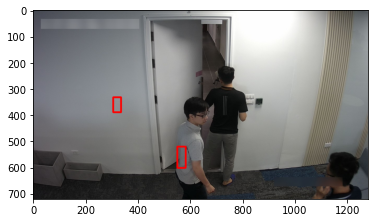

In [692]:
import matplotlib.pyplot as plt
import pickle as pkl 


rotate = RandomRotate(15)  

img = cv2.imread("messi.jpg")[:,:,::-1] #OpenCV uses BGR channels
bboxes = pkl.load(open("messi_ann.pkl", "rb"))

img, bboxes = rotate(img, bboxes)


plt.imshow(draw_rect(img, bboxes))




In [711]:
with open('prediction/hello.txt', 'w') as f:
    f.write("hehe")
    

In [751]:
import glob 
from random import shuffle
from shutil import copy2

allfiles = glob.glob("crop_img/images/*")

# Split 8/2
shuffle(allfiles)
os.makedirs('dataset82/images/train')
os.makedirs('dataset82/labels/train')
os.makedirs('dataset82/images/val')
os.makedirs('dataset82/labels/val')
for i, file in enumerate(allfiles):
    text = file.replace("images", "labels")
    text = text.replace("jpg", "txt")
    if i < len(allfiles)*0.8: #training
        copy2(file, 'dataset82/images/train')
        copy2(text, 'dataset82/labels/train')
    else:
        copy2(file, 'dataset82/images/val')
        copy2(text, 'dataset82/labels/val')
        

In [726]:
def save_img(img, filename, dir):
    file_path = os.path.join(dir, filename)
    
    im = Image.fromarray(img)
    im.save(file_path)
    

In [725]:
import imutils

img = cv2.imread('dataset82/images/train/1.jpg', cv2.IMREAD_COLOR) #OpenCV uses BGR channels
rotated = imutils.rotate(img, angle=15)




# # file_path = 'prediction'
    
# # rotated.save(file_path)


# from PIL import Image
# im = Image.fromarray(rotated)
# im.save("prediction/your_file.jpg")



AttributeError: 'NoneType' object has no attribute 'shape'

In [723]:
rotated

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)